## Basic Model

Now that we have an easy dataset to use, let's try out a basic image classification model on it.

In [1]:
from fastai.core import *
from fastai.vision import *
from fastai.vision.models import resnet18, resnet101
from fastai.callbacks import *

In [2]:
path = Path('../data/EasyDeepFakes')

In [4]:
src = ImageList.from_folder(path).split_by_folder(train='train', valid='val')


In [5]:
bs, sz = 32, 128

In [7]:
def get_data(bs,size):
    data = (src.label_from_re('([A-Z]+).png$')
           .transform(get_transforms(max_warp=0, max_zoom=1), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    return data

In [8]:
data = get_data(bs, sz)

## MesoNet

In [9]:
from kgl_deepfake.models import *

In [10]:
#export
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduction='elementwise_mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction is None:
            return F_loss
        else:
            return torch.mean(F_loss)

In [23]:
learner = Learner(data, MesoNet(), metrics=[accuracy], callback_fns=ActivationStats)

In [25]:
#learner.loss_fn = FocalLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


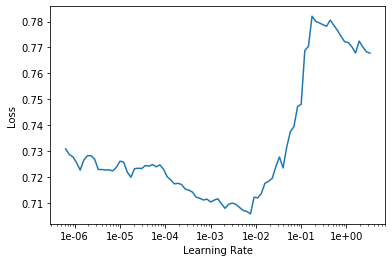

In [26]:
learner.lr_find()
learner.recorder.plot()

In [27]:
learner.fit_one_cycle(25, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.716082,0.707725,0.483544,00:02
1,0.709448,0.694835,0.536709,00:02
2,0.693406,0.675159,0.584810,00:02
3,0.674617,0.675947,0.594937,00:02
4,0.670460,0.661263,0.610127,00:02
5,0.654290,0.656445,0.607595,00:02
6,0.635215,0.702371,0.607595,00:02
7,0.628745,0.601138,0.648101,00:02
8,0.624698,0.587374,0.673418,00:02
9,0.619754,0.594688,0.622785,00:02


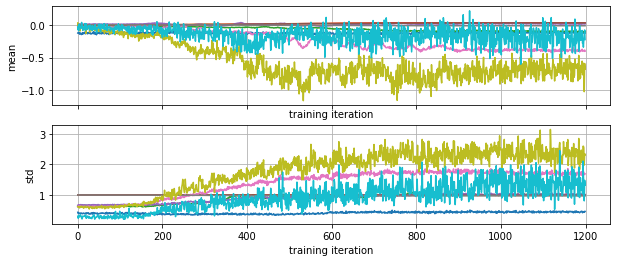

In [28]:
stats = learner.activation_stats.stats

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 4), sharex=True)
axs = axs.flatten()
for imod in range(stats.shape[1]):
    for ax, n, stat in zip(axs, ['mean', 'std'], stats[:,imod,:]):
        ax.plot(stat)
        ax.set_ylabel(n)
        ax.set_xlabel('training iteration')
        ax.grid(b=True)

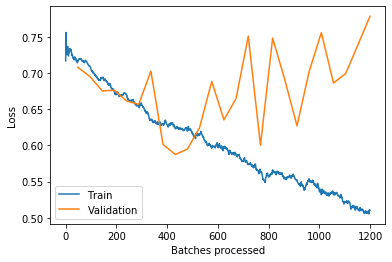

In [29]:
learner.recorder.plot_losses()

In [30]:
interp = ClassificationInterpretation.from_learner(learner)

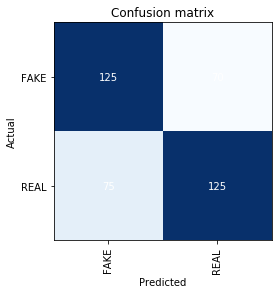

In [32]:
interp.plot_confusion_matrix()

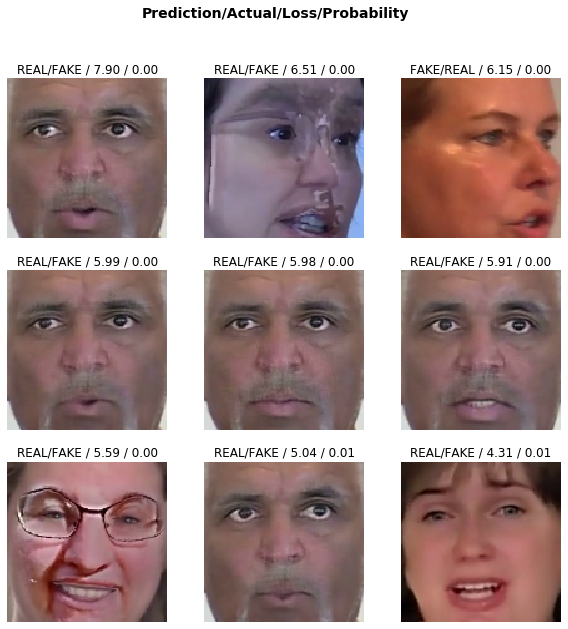

In [33]:
interp.plot_top_losses(9, figsize=(10,10))